# JP Morgan Quantitative Research Task 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
# Reading data and converting datatype
df = pd.read_csv("Nat_Gas.csv")
display(type(df))
df.index = pd.to_datetime(df["Dates"])
# display(df)
# df["Month"] = df["Dates"].dt.month
# df["Year"] = df["Dates"].dt.year
df = df.drop(columns=['Dates'])
display(df.head())
display(df.index)
display(type(df.index))

pandas.core.frame.DataFrame

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


DatetimeIndex(['2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
               '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30'],
              dtype='datetime64[ns]', name='Dates', freq=None)

pandas.core.indexes.datetimes.DatetimeIndex

## Visualisation 
- Higher in March, lower in July
- Overall increasing over time

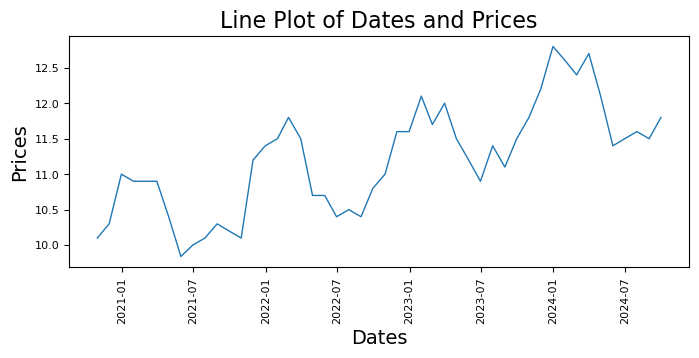

In [3]:
plt.figure(figsize=(8, 3))
xticks = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
# plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.xticks(fontsize=8, rotation="vertical")
plt.yticks(fontsize=8)
plt.plot(df, linewidth=1)

# Changing font size of axis labels
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Prices', fontsize=14)

# Changing font size of title
plt.title('Line Plot of Dates and Prices', fontsize=16)
plt.show()

## Splitting training and testing data

In [4]:
# Split such that 1 year will be test data
split_date = '20230930'
df_train = df[df.index <= split_date]
df_test = df[df.index >  split_date]
df_train.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


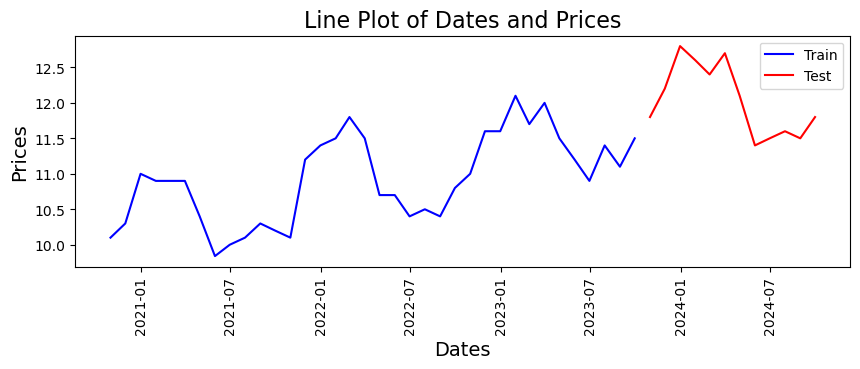

In [5]:
plt.figure(figsize=(10, 3))
train_df_sort = df_train.sort_index()
test_df_sort = df_test.sort_index()

plt.plot(train_df_sort, "b", label="Train")
plt.plot(test_df_sort, "r", label="Test")

# Changing font size of axis labels
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Prices', fontsize=14)

# Changing font size of title
plt.title('Line Plot of Dates and Prices', fontsize=16)
plt.xticks(rotation="vertical")
plt.legend();

## Evaluating data
### Using POSIX time for time series data

In [6]:
X = (df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9) # convert to POSIX time by dividing by 10**9
y = df.values

X_train, X_test = X[:36], X[36:]
y_train, y_test = y[:36], y[36:]

print(X_train[:10])
print(y_train[:10])

[[1604102400]
 [1606694400]
 [1609372800]
 [1612051200]
 [1614470400]
 [1617148800]
 [1619740800]
 [1622419200]
 [1625011200]
 [1627689600]]
[[10.1 ]
 [10.3 ]
 [11.  ]
 [10.9 ]
 [10.9 ]
 [10.9 ]
 [10.4 ]
 [ 9.84]
 [10.  ]
 [10.1 ]]


In [7]:
# Code credit: Adapted from the following:
# https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/
# https://github.com/UBC-CS/cpsc330-2024s/blob/main/lectures/mehrdad/19_time-series.ipynb
import datetime

def eval_on_features(features, target, regressor, n_train=36, sales_data=False, 
                     ylabel='Price', 
                     feat_names="Default", 
                     impute=True):
    """
    Evaluate a regression model on a given set of features and target.

    This function splits the data into training and test sets, fits the 
    regression model to the training data, and then evaluates and plots 
    the performance of the model on both the training and test datasets.

    Parameters:
    -----------
    features : array-like
        Input features for the model.
    target : array-like
        Target variable for the model.
    regressor : model object
        A regression model instance that follows the scikit-learn API.
    n_train : int, default=36
        The number of samples to be used in the training set.
    sales_data : bool, default=False
        Indicates if the data is sales data, which affects the plot ticks.
    ylabel : str, default='Rentals'
        The label for the y-axis in the plot.
    feat_names : str, default='Default'
        Names of the features used, for display in the plot title.
    impute : bool, default=True
        whether SimpleImputer needs to be applied or not

    Returns:
    --------
    None
        The function does not return any value. It prints the R^2 score
        and generates a plot.
    """

    # Split the features and target data into training and test sets
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]

    if impute:
        simp = SimpleImputer()
        X_train = simp.fit_transform(X_train)
        X_test = simp.transform(X_test)
    
    # Fit the model on the training data
    regressor.fit(X_train, y_train)
    # print(X_test)

    # Print R^2 scores for training and test datasets
    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)))
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))

    # Predict target variable for both training and test datasets
    y_pred_train = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)

    # Plotting
    plt.figure(figsize=(10, 3))

    # Adjust x-ticks for dates (assumes datetime format)
    if not sales_data: 
        plt.xticks(range(0, len(X), 1), [dt.strftime("%m/%Y") for dt in df.index], rotation=90, ha="left")

    # Plot training and test data, along with predictions
    plt.plot(range(n_train), y_train, label="Train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, "-", label="Test")
    plt.plot(range(n_train), y_pred_train, "--", label="Prediction Train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, "--", label="Prediction Test")

    # Set plot title, labels, and legend
    title = regressor.__class__.__name__ + "\n Features= " + feat_names
    plt.title(title)
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Time")
    plt.ylabel(ylabel)

### POSIX time feature only
- Cannot extrapolate to feature ranges outside the training data.
- As such, for most cases testing predictions will simply be linear.

Train-set R^2: -902.22
Test-set R^2: -7913.50


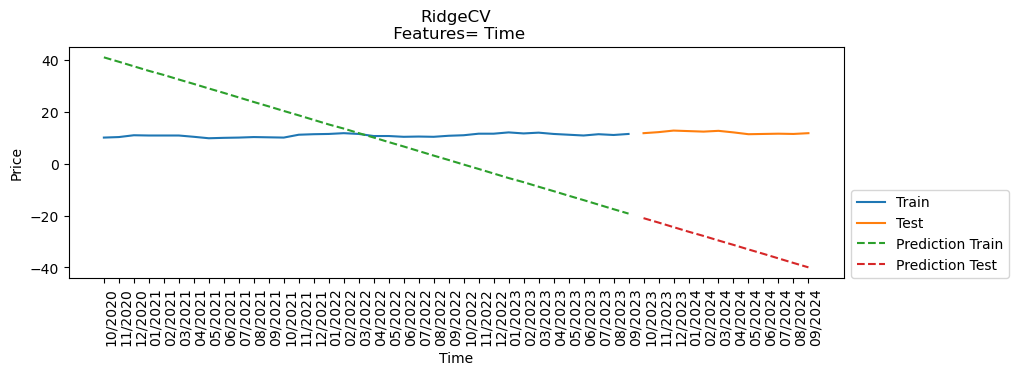

In [8]:
lr_regressor = RidgeCV()
eval_on_features(X, y, lr_regressor, feat_names="Time", impute = True)

/Users/student/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train-set R^2: 0.96
Test-set R^2: -1.78


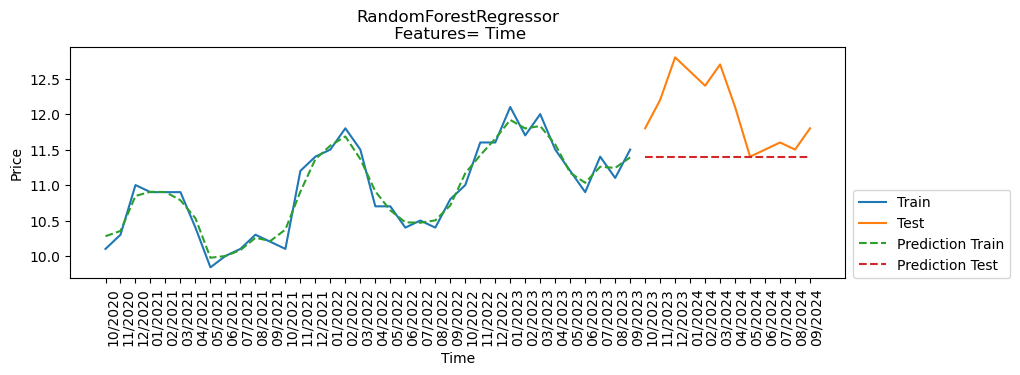

In [9]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=76)
eval_on_features(X, y, rf_regressor, feat_names="Time", impute = True)

/Users/student/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train-set R^2: 0.00
Test-set R^2: -5.23


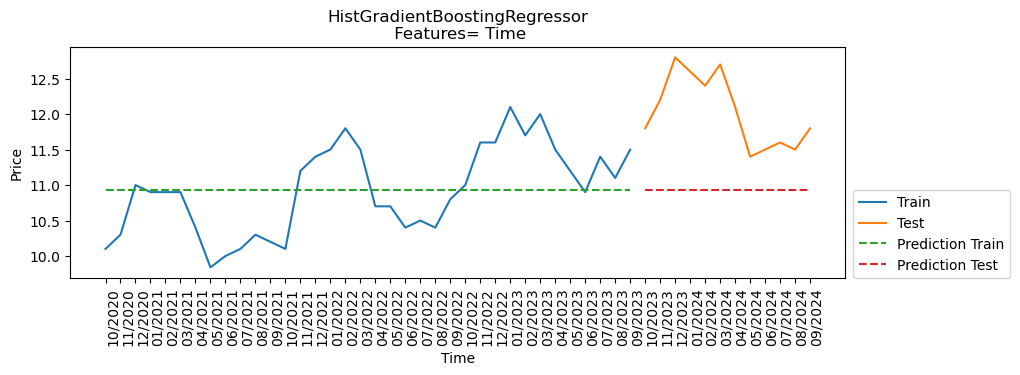

In [10]:
histGB_regressor = HistGradientBoostingRegressor(random_state=76,)
eval_on_features(X, y, histGB_regressor, feat_names="Time", impute = True)

### Adding Month and Year Features
- `RidgeCV()` cannot capture periodic pattern, but can capture overall increase in values over time
- `RandomForestRegressor()` can capture pattern, but fails to capture overall increase in values over time
- General difficulty in capturing periodic patterns due to no one-hot encoding of months
- Will ignore `HistGradientBoostingRegressor()` from this point onwards due to lack of changes on results

In [11]:
print(type(df.index))
X_year_month = np.hstack(
    [
        df.index.year.values.reshape(-1, 1),
        df.index.month.values.reshape(-1, 1),
    ]
)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Train-set R^2: 0.40
Test-set R^2: -0.78


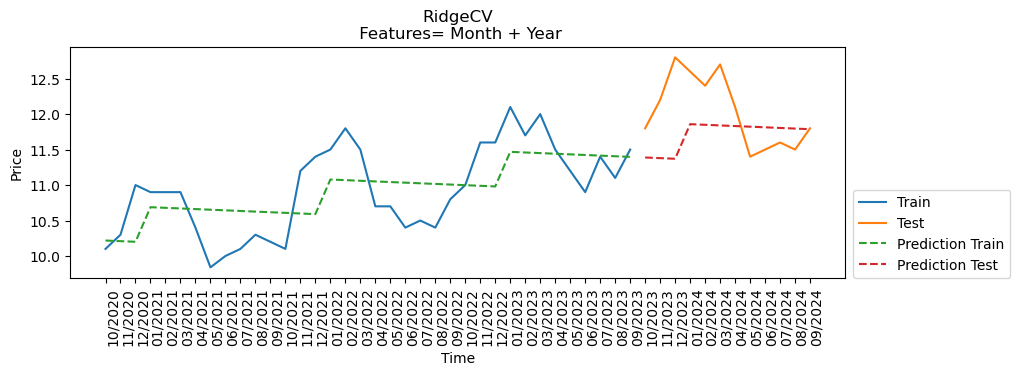

In [12]:
lr_regressor = RidgeCV()
eval_on_features(X_year_month, y, lr_regressor, feat_names="Month + Year", impute = True)

/Users/student/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train-set R^2: 0.97
Test-set R^2: -0.77


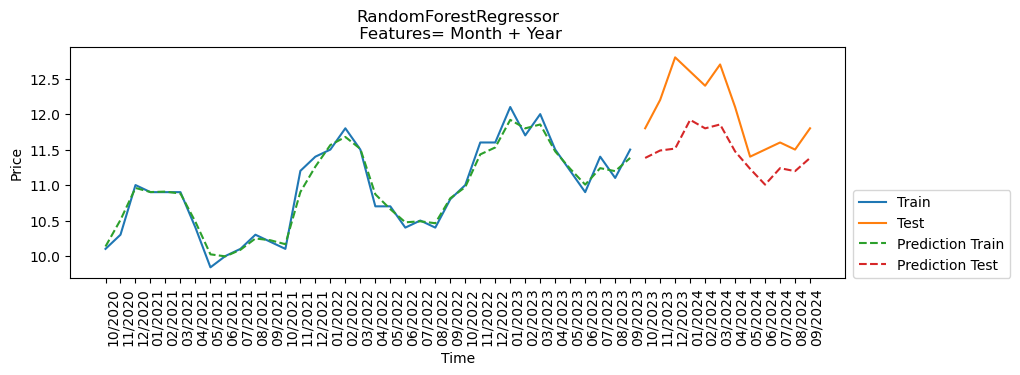

In [13]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=76)
eval_on_features(X_year_month, y, rf_regressor, feat_names="Month + Year", impute = True)

/Users/student/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train-set R^2: 0.00
Test-set R^2: -5.23


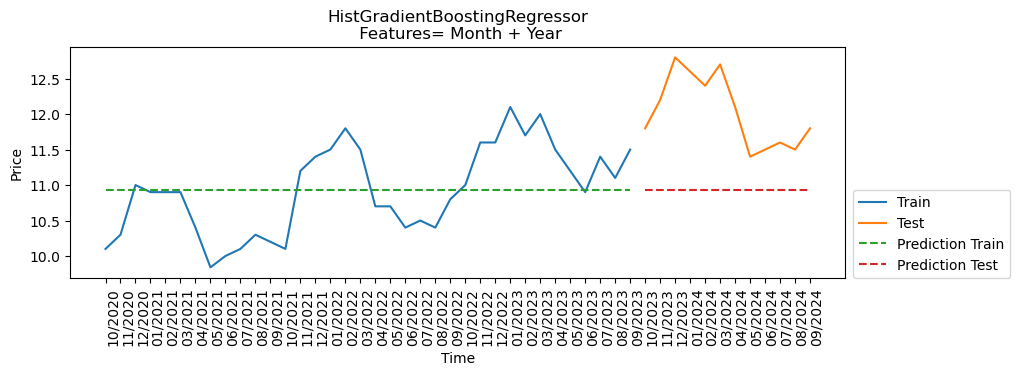

In [14]:
histGB_regressor = HistGradientBoostingRegressor(random_state=76,)
eval_on_features(X_year_month, y, histGB_regressor, feat_names="Month + Year", impute = True)

### OHE on Months and Interaction Features between variables
- Application of OHE and interaction features heavily improves `Ridge()`
- `RandomForestRegressor()` produces similar results to before since it cannot capture the overall increase of price over time

In [15]:
enc = OneHotEncoder()
X_year_month_onehot = np.hstack(
    [
        df.index.year.values.reshape(-1, 1),
        enc.fit_transform(df.index.month.values.reshape(-1, 1)).toarray(),
    ]
)
X_year_month_onehot[0:5]

array([[2.020e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.020e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.020e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.021e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.021e+03, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]])

In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(
    interaction_only=True, include_bias=False
)
X_year_month_onehot_poly = poly_transformer.fit_transform(X_year_month_onehot)
display(X_year_month_onehot_poly.shape)

(48, 91)

Train-set R^2: 0.94
Test-set R^2: 0.83


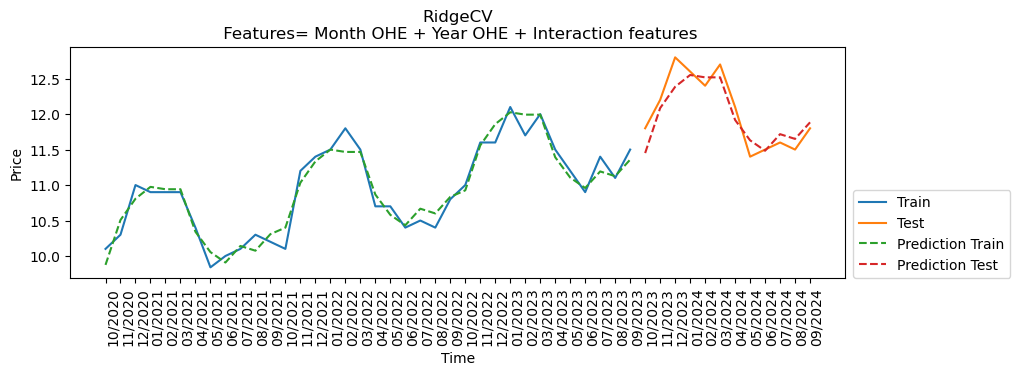

In [17]:
lr_regressor = RidgeCV()
eval_on_features(X_year_month_onehot_poly, y, lr_regressor, feat_names="Month OHE + Year OHE + Interaction features", impute = True)

/Users/student/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train-set R^2: 0.94
Test-set R^2: -0.90


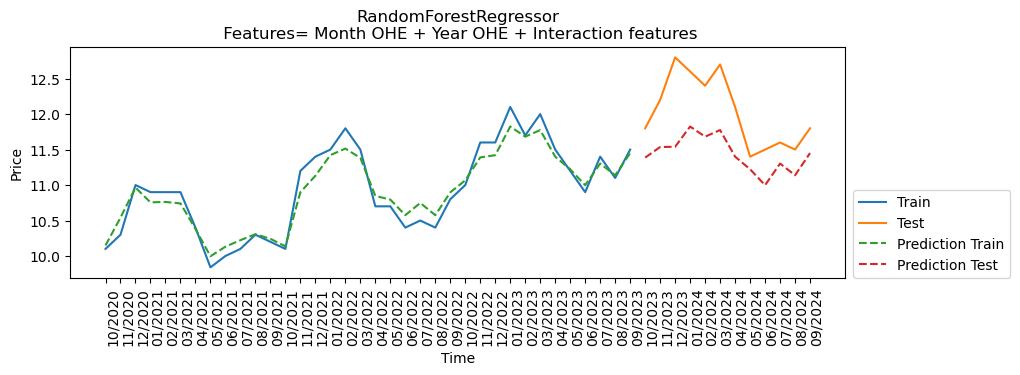

In [18]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=76)
eval_on_features(X_year_month_onehot_poly, y, rf_regressor, feat_names="Month OHE + Year OHE + Interaction features", impute = True)

### Lag based features
- Want to account for temporal dependence
- Better than default, worse than OHE and interaction features combined

In [19]:
def create_lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [20]:
df_lag5 = create_lag_df(df, 5, ['Prices'])
display(df_lag5.head(7))
display(df_lag5.shape)

,Prices,Prices-1,Prices-2,Prices-3,Prices-4,Prices-5
Dates,,,,,,
2020-10-31,10.1,NaN,NaN,NaN,NaN,NaN
2020-11-30,10.3,10.1,NaN,NaN,NaN,NaN
2020-12-31,11.0,10.3,10.1,NaN,NaN,NaN
2021-01-31,10.9,11.0,10.3,10.1,NaN,NaN
2021-02-28,10.9,10.9,11.0,10.3,10.1,NaN
2021-03-31,10.9,10.9,10.9,11.0,10.3,10.1
2021-04-30,10.4,10.9,10.9,10.9,11.0,10.3


(48, 6)

In [21]:
X_lag_features = df_lag5.drop(columns = ['Prices']).to_numpy()
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)

Train-set R^2: 0.59
Test-set R^2: -0.39


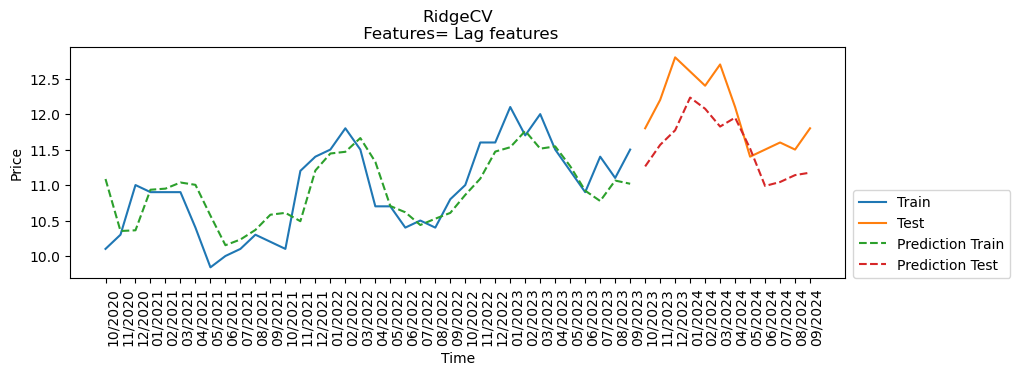

In [22]:
lr_regressor = RidgeCV()
eval_on_features(X_lag_features_imp, y, lr_regressor, feat_names="Lag features", impute="yes")

/Users/student/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train-set R^2: 0.91
Test-set R^2: -2.35


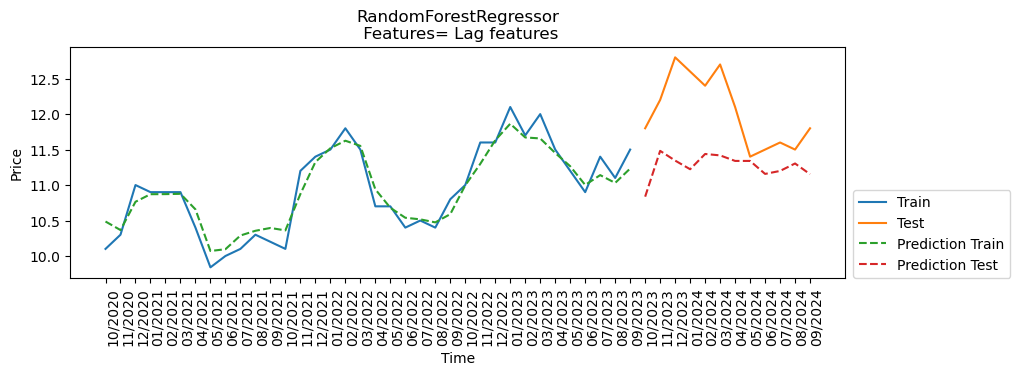

In [23]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=76)
eval_on_features(X_lag_features_imp, y, rf_regressor, feat_names="Lag features")

## OHE on Months, Interaction Features, Lag Features
- `RidgeCV()` appears to work more effectively on training data and testing data compared to `RandomForestRegressor()` 

In [24]:
X_year_month_onehot_poly_lag = np.hstack(
    [X_year_month_onehot_poly, X_lag_features]
)

Train-set R^2: 0.94
Test-set R^2: 0.81


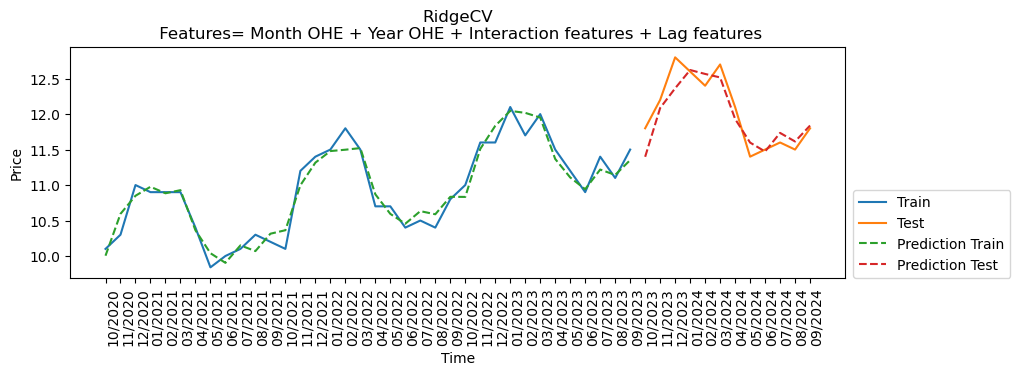

In [25]:
lr_regressor = RidgeCV()
eval_on_features(X_year_month_onehot_poly_lag, y, lr_regressor, feat_names="Month OHE + Year OHE + Interaction features + Lag features", impute="yes")

/Users/student/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train-set R^2: 0.93
Test-set R^2: -1.58


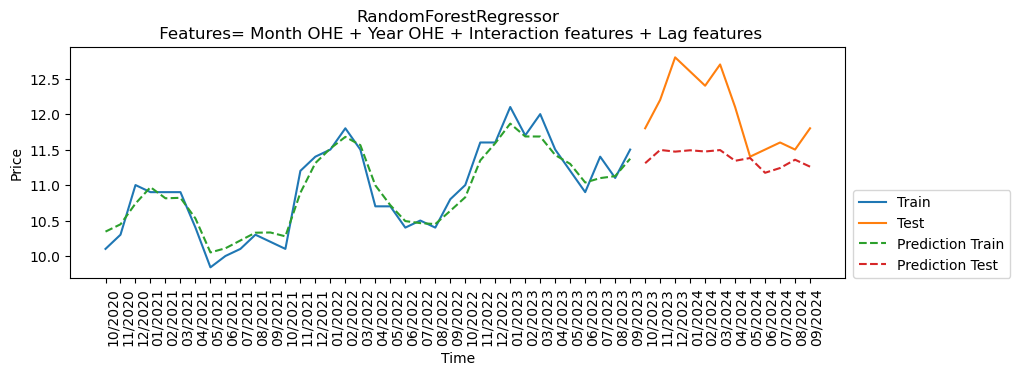

In [26]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=76)
eval_on_features(X_year_month_onehot_poly_lag, y, rf_regressor, feat_names="Month OHE + Year OHE + Interaction features + Lag features", impute="yes")

## Final estimator 
- Due to the results without lag features producing a slightly higher training `R^2` score than with lag features, the estimator could work without requiring past data
- Operates under the assumption that price will increase indefinitely over the years, and will have the same pattern of price changes across months

In [27]:
from dateutil.relativedelta import relativedelta

df_new = pd.read_csv("Nat_Gas.csv")[36:] # Last 12 months of data
display(df_new)
print(df_new.shape)
df_new.index = [pd.to_datetime(x) + relativedelta(years=1) for x in df_new["Dates"]] # Extrapolate for 1 year into the future

df_new = df_new.drop(columns=['Dates', 'Prices'])
df_new.index.name = "Dates"

display(df_new.index)

,Dates,Prices
36,10/31/23,11.8
37,11/30/23,12.2
38,12/31/23,12.8
39,1/31/24,12.6
40,2/29/24,12.4
41,3/31/24,12.7
42,4/30/24,12.1
43,5/31/24,11.4
44,6/30/24,11.5
45,7/31/24,11.6


(12, 2)


DatetimeIndex(['2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [28]:
X_new = (df_new.index.astype("int64").values.reshape(-1, 1) // 10 ** 9)

# enc = OneHotEncoder()
X_new_year_month_onehot = np.hstack(
    [
        df_new.index.year.values.reshape(-1, 1),
        enc.transform(df_new.index.month.values.reshape(-1, 1)).toarray(),
    ]
)
poly_transformer = PolynomialFeatures(
    interaction_only=True, include_bias=False
)

X_year_month_onehot_poly = poly_transformer.fit_transform(X_year_month_onehot)
X_new_year_month_onehot_poly = poly_transformer.transform(X_new_year_month_onehot)

lr_regressor_nolag = RidgeCV()
lr_regressor_nolag.fit(X_year_month_onehot_poly, y)
# display(X_year_month_onehot_poly.shape)
df_new["Prices"] = lr_regressor_nolag.predict(X_new_year_month_onehot_poly)
display(df_new)

,Prices
Dates,
2024-10-31,12.101660
2024-11-30,12.677377
2024-12-31,13.052808
2025-01-31,13.127239
2025-02-28,13.052062
2025-03-31,13.127252
2025-04-30,12.526510
2025-05-31,12.135981
2025-06-30,12.050865


In [29]:
# X_year_month_onehot_poly_lag = np.hstack(
#     [X_year_month_onehot_poly, X_lag_features]
# )
# X_new_year_month_onehot_poly_lag

# lr_regressor_lag = RidgeCV()
# lr_regressor_lag.fit(X_year_month_onehot_poly_lag, y)
# # display(X_year_month_onehot_poly_lag.shape)
# df_new["Prices + Lag"] = lr_regressor_lag.predict(X_new_year_month_onehot_poly_lag)
# display(df_new)

<Figure size 640x480 with 0 Axes>

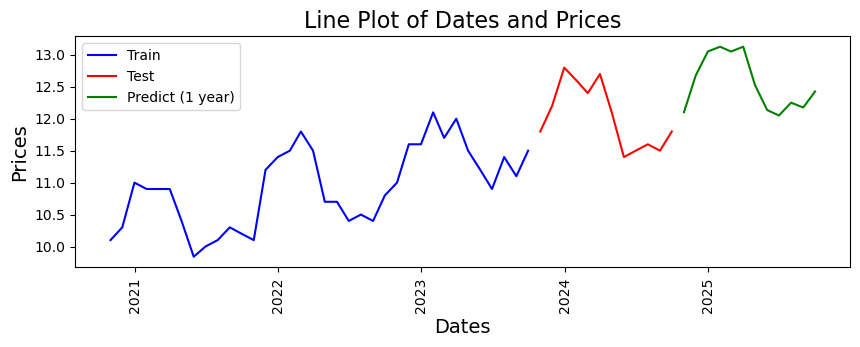

In [30]:
plt.clf()
plt.figure(figsize=(10, 3))
train_df_sort = df_train.sort_index()
test_df_sort = df_test.sort_index()
new_df_sort = df_new.sort_index()

plt.plot(train_df_sort, color = "blue", label="Train")
plt.plot(test_df_sort, color = "red", label="Test")
plt.plot(new_df_sort, color = "green", label="Predict (1 year)")

# Changing font size of axis labels
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Prices', fontsize=14)

# Changing font size of title
plt.title('Line Plot of Dates and Prices', fontsize=16)
plt.xticks(rotation="vertical")
plt.legend();

In [31]:
def pricepredict(datelist):
    """
    Predict prices for given list of dates datelist, based on their month and year
    
    Parameters:
    -----------
    datelist : array-like
        List of dates in the form %Y-%m-%d

    Returns:
    --------
    Table of prices and their corresponding values
    """
    list = pd.DatetimeIndex([pd.to_datetime(x) for x in datelist])
    table = pd.DataFrame([], index = list, columns=['Prices'])
    table.index.name = "Dates"
    val = np.hstack(
        [
            table.index.year.values.reshape(-1, 1),
            enc.transform(table.index.month.values.reshape(-1, 1)).toarray(),
        ]
    )
    table["Prices"] = lr_regressor_nolag.predict(poly_transformer.transform(val))
    return table

In [32]:
pricepredict([
    '2024-10-31', "2024-11-30", "2024-12-31", "2025-01-31", 
    "2025-02-28", "2025-03-31", "2025-04-30", "2025-05-31", 
    "2025-06-30", "2025-07-31", "2025-08-31", "2025-09-30"
])

,Prices
Dates,
2024-10-31,12.101660
2024-11-30,12.677377
2024-12-31,13.052808
2025-01-31,13.127239
2025-02-28,13.052062
2025-03-31,13.127252
2025-04-30,12.526510
2025-05-31,12.135981
2025-06-30,12.050865
